In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import IPython.utils.io
import tqdm
import gtsam
import sln_letter_fit, sln_fit
from fit_types import FitParams, OptimizationLoggingParams, LetterSolutionAndHistory, LetterSolution
import loader, plotting2
import utils
from utils import Time

%aimport -numpy
%aimport -matplotlib
%aimport -IPython
%aimport -tqdm
%aimport -gtsam

# Setup

total letter duration is approx 0.96667s


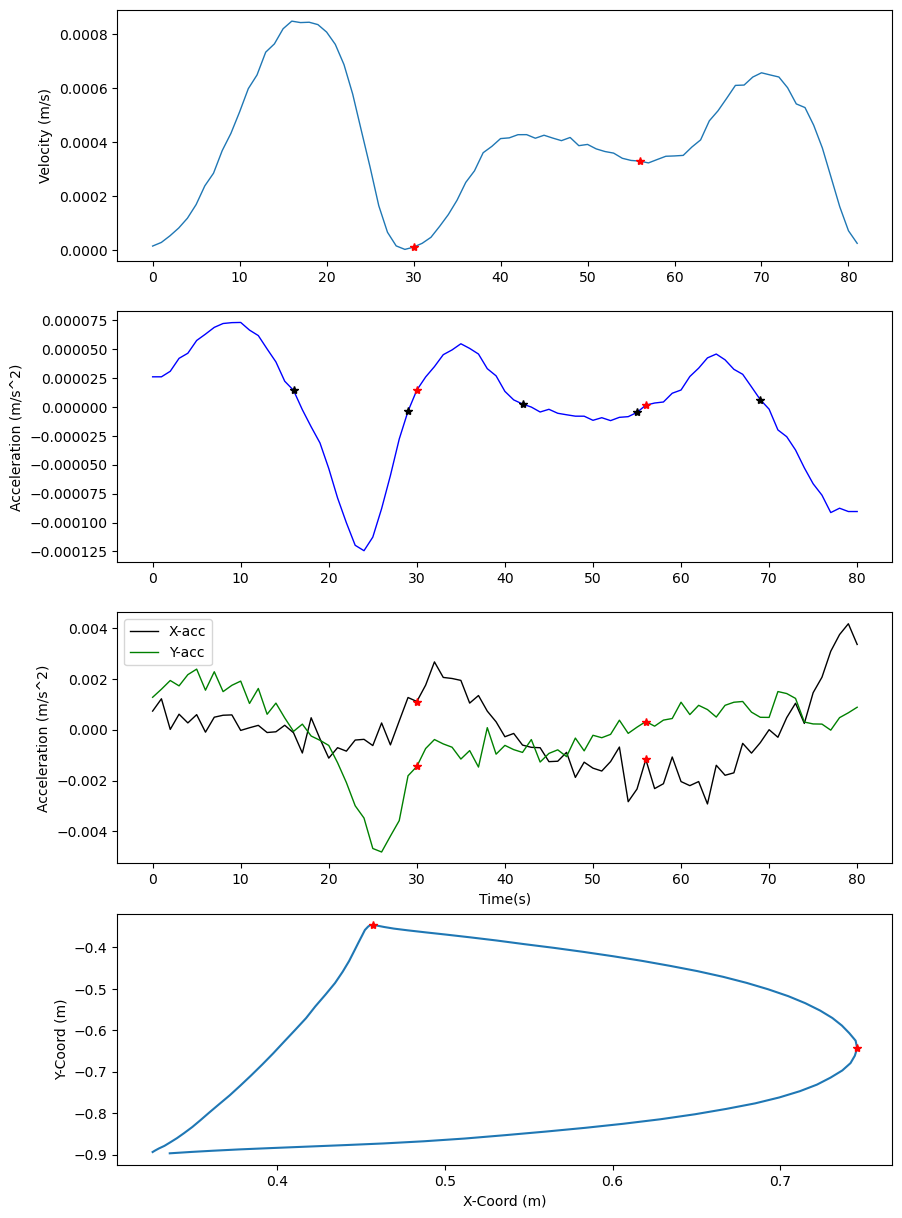

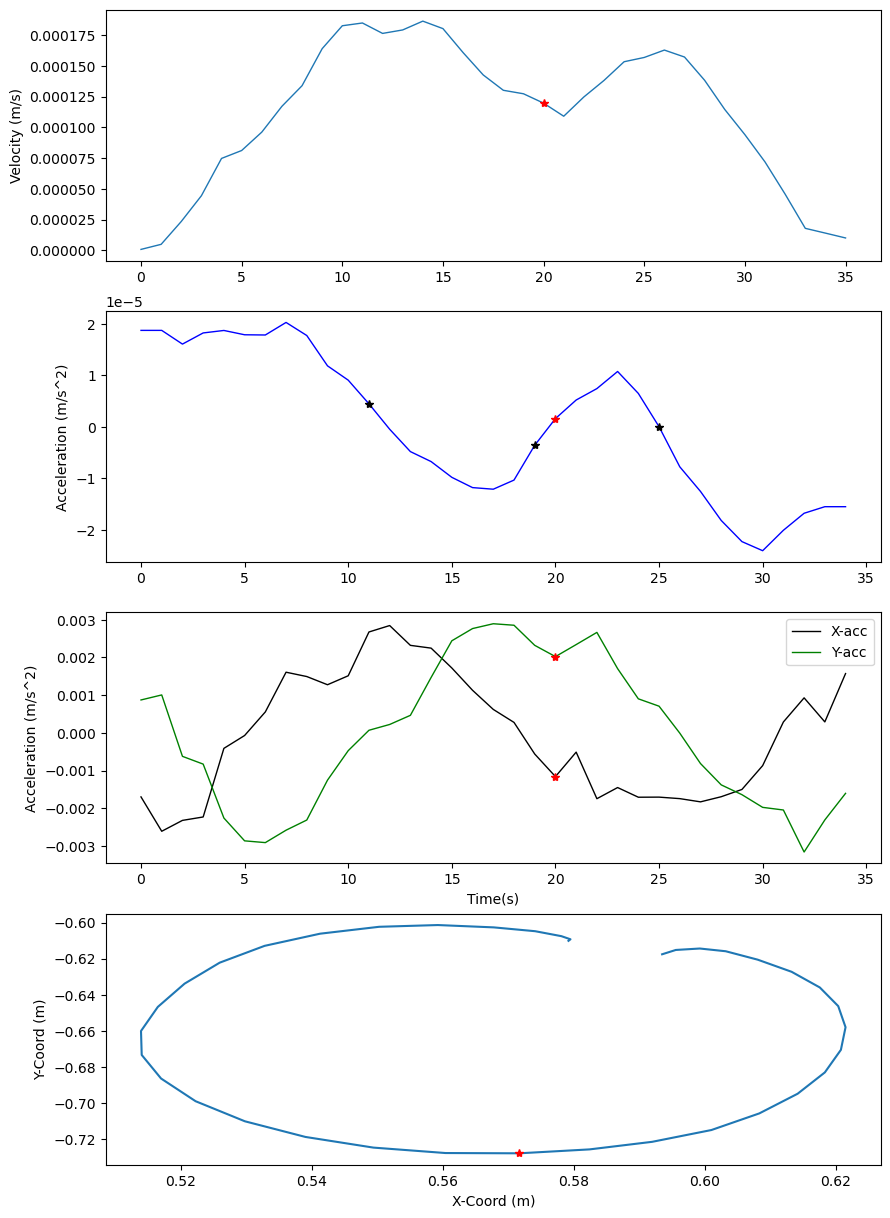

In [6]:
letter_data = loader.load_segments('D', index=None, debug=True)
print(f'total letter duration is approx {sum(traj[-1][-1, 0] for traj in letter_data):.5f}s')

In [34]:
def iterating_sol_to_direct_sol(letter_sol_and_history: LetterSolutionAndHistory) -> LetterSolution:
    return LetterSolution(
        params=[sol['params'] for sol, _ in letter_sol_and_history],
        txy=[sol['txy_from_params'] for sol, _ in letter_sol_and_history],
        data=[np.vstack(trajectory) for trajectory in letter_data],
        all_stroke_indices=[sol['stroke_indices'] for sol, _ in letter_sol_and_history])

In [35]:
def do_integrating_strokewise(letter_data):
    with Time('Integrating Version, Strokewise') as t:
        sol = sln_letter_fit.fit_letter(letter_data,
                                        max_iters=100,
                                        fit_params_kwargs={'strokewise': True},
                                        use_2_stage=False)
        return t(), iterating_sol_to_direct_sol(sol)
def do_integrating_connected(letter_data):
    with Time('Integrating Version, Connected') as t:
        sol = sln_letter_fit.fit_letter(letter_data, max_iters=100, use_2_stage=False)
        return t(), iterating_sol_to_direct_sol(sol)
def do_direct_strokewise(letter_data):
    with Time('Direct Version, Strokewise') as t:
        lm_params = utils.create_params(absoluteErrorTol=0, relativeErrorTol=0, errorTol=0)
        sol = sln_fit.fit_letter(letter_data,
                                 fit_params=sln_fit.FitLetterParams(lm_params=lm_params,
                                                                    strokewise=True))
        return t(), sol
def do_direct_connected(letter_data):
    with Time('Direct Version, Connected') as t:
        lm_params = utils.create_params(absoluteErrorTol=0, relativeErrorTol=0, errorTol=0)
        sol = sln_fit.fit_letter(
            letter_data,
            fit_params=sln_fit.FitLetterParams(
                lm_params=lm_params,
                #  noise_model_connecting=gtsam.noiseModel.Isotropic.Sigma(2, 1e-2)
            ))
        return t(), sol

# Run one optimization using each method, and plot

In [36]:
t_integrating_strokewise, sol_integrating_strokewise = do_integrating_strokewise(letter_data)

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Integrating Version, Strokewise took 0.93149 seconds


NameError: name 'sol_integrating_connected' is not defined

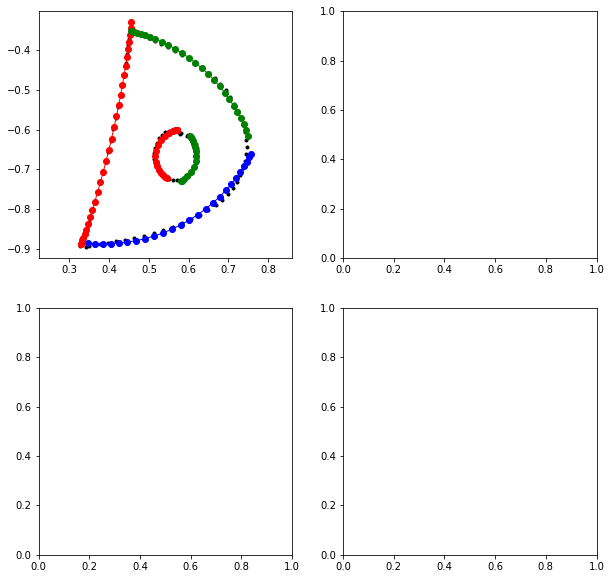

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
plotting2.plot_letter(axes[0][0], sol_integrating_strokewise, disp_params=False)
plotting2.plot_letter(axes[1][0], sol_integrating_connected, disp_params=False)
plotting2.plot_letter(axes[0][1], sol_direct_strokewise, disp_params=False)
plotting2.plot_letter(axes[1][1], sol_direct_connected, disp_params=False)

axes[0][0].set_title(f'Integrating Strokewise (t = {t_integrating_strokewise:.5f}s)', fontsize=20)
axes[1][0].set_title(f'Integrating Connected (t = {t_integrating_connected:.5f}s)', fontsize=20)
axes[0][1].set_title(f'Direct Strokewise (t = {t_direct_strokewise:.5f}s)', fontsize=20)
axes[1][1].set_title(f'Direct Connected (t = {t_direct_connected:.5f}s)', fontsize=20);

# Timing Test

In [ ]:
t_integrating_strokewise = []
t_integrating_connected = []
t_direct_strokewise = []
t_direct_connected = []
for _ in tqdm.notebook.trange(10):
    with IPython.utils.io.capture_output():
        t_integrating_strokewise.append(do_integrating_strokewise(letter_data)[0])
        t_integrating_connected.append(do_integrating_connected(letter_data)[0])
        t_direct_strokewise.append(do_direct_strokewise(letter_data)[0])
        t_direct_connected.append(do_direct_connected(letter_data)[0])
disp = lambda name, t: print(f'{name:30} : {np.mean(t):.5f} +/- {np.std(t):.5f} seconds')
disp('t_integrating_strokewise', t_integrating_strokewise)
disp('t_integrating_connected', t_integrating_connected)
disp('t_direct_strokewise', t_direct_strokewise)
disp('t_direct_connected', t_direct_connected)